## Modeling scRNA-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell


In [88]:
import pandas as pd
import numpy as np
import os
import seaborn
import itertools
import glob

import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [89]:
# these are motifs used during training (pre-weights)
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [90]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [91]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [92]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.Mubind
import torch
import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [93]:
device = 'cpu'

In [94]:
import scanpy as sc

In [95]:
print('here...')

here...


In [96]:
# pybiomart is requred
annot = sc.queries.biomart_annotations(
    "mmusculus",
    ["ensembl_gene_id", "start_position", "end_position", "chromosome_name"],
).set_index("ensembl_gene_id")
# rna.var[annot.columns] = annot

In [97]:
# load the pancreas multiome dataset
rna = sc.read_h5ad('noack_et_al_velocity_graph.h5ad')
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

In [98]:
rna.var['tss_start'] = np.where(rna.var['Strand'] == '+', rna.var['Start'], rna.var['End'])
rna.var['tss_start'], rna.var['tss_end'] = rna.var['tss_start'] - 100, rna.var['tss_start'] + 100

In [99]:
rna.var['k'] = 'chr' + rna.var['Chromosome'].astype(str) + ':' + rna.var['tss_start'].astype(str) + '-' + rna.var['tss_end'].astype(str)

In [100]:
rna.var['k'] 

index
Xkr4           chr1:3671398-3671598
Rgs20          chr1:5070185-5070385
Slco5a1      chr1:12992550-12992750
Jph1         chr1:17097789-17097989
Mcm3         chr1:20820212-20820412
                     ...           
Rai2       chrX:161716969-161717169
Ap1s2      chrX:163908917-163909117
Ddx3y          chrY:1286529-1286729
Eif2s3y        chrY:1010443-1010643
Gm47283      chrY:90784638-90784838
Name: k, Length: 2000, dtype: object

In [101]:
# rna.shape, atac.shape
# atac_path = '../../../annotations/scatac/noack_et_al_velocity_graph.h5ad'
# os.path.exists(atac_path)
# ad = sc.read_h5ad(atac_path)

In [102]:
ad = rna

In [103]:
ad.var_names

Index(['Xkr4', 'Rgs20', 'Slco5a1', 'Jph1', 'Mcm3', 'Ogfrl1', 'Prim2', 'Bag2',
       'Bend6', 'Aff3',
       ...
       'Tmem35a', 'Pak3', 'Alas2', 'Smc1a', 'Sh3kbp1', 'Rai2', 'Ap1s2',
       'Ddx3y', 'Eif2s3y', 'Gm47283'],
      dtype='object', name='index', length=2000)

In [104]:
ad.var.k

index
Xkr4           chr1:3671398-3671598
Rgs20          chr1:5070185-5070385
Slco5a1      chr1:12992550-12992750
Jph1         chr1:17097789-17097989
Mcm3         chr1:20820212-20820412
                     ...           
Rai2       chrX:161716969-161717169
Ap1s2      chrX:163908917-163909117
Ddx3y          chrY:1286529-1286729
Eif2s3y        chrY:1010443-1010643
Gm47283      chrY:90784638-90784838
Name: k, Length: 2000, dtype: object

In [105]:
ad

AnnData object with n_obs × n_vars = 7469 × 2000
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'varian

In [106]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


In [107]:
rna.obs

,Clusters,_X,_Y,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,louvain,clusters,velocity_self_transition,root_cells,end_points,velocity_pseudotime,latent_time
index,,,,,,,,,,,,,,
E14_rep1_AAACGCTGTGCCTGCA,6,19.532391,31.076675,10651,21936,21936.0,11999.879883,NSC_M,NSC_M,0.142809,0.080724,0.059477,0.010955,0.068471
E14_rep1_AACAAAGTCGTTGCCT,10,-0.813388,-39.778297,8612,24454,24454.0,12080.375000,NSC_M,NSC_M,0.180630,0.049012,0.037526,0.019589,0.058806
E14_rep1_AAAGGGCAGAGGACTC,7,-6.443579,-6.468434,6950,20005,20005.0,12004.696289,NSC_M,NSC_M,0.203534,0.046236,0.010296,0.029837,0.052703
E14_rep1_AAAGTCCGTTCTAACG,8,-17.291636,1.845977,8869,17962,17962.0,11969.920898,N1,N1,0.434577,0.000241,0.000441,0.659416,0.655443
E14_rep1_AAAGAACAGTGGTGAC,1,-34.118580,-15.784664,6007,10419,10419.0,11907.895508,N1,N1,0.317549,0.000003,0.000280,0.579727,0.628572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E14_rep2_TTTACCAAGCAGTCTT,7,-21.630602,37.928932,5585,11564,11564.0,11912.550781,N2,N2,0.249250,0.000912,0.000131,0.720113,0.542176
E14_rep2_TTTAGTCAGGGCAGGA,1,-25.069689,-7.479694,2737,8372,8372.0,11943.799805,IPC,IPC,0.034774,0.000293,0.000063,0.525756,0.498404
E14_rep2_TTGTTCATCTGGGAGA,0,37.018669,-7.389564,3338,10408,10408.0,12035.953125,IPC,IPC,0.131312,0.037047,0.000625,0.527455,0.422540


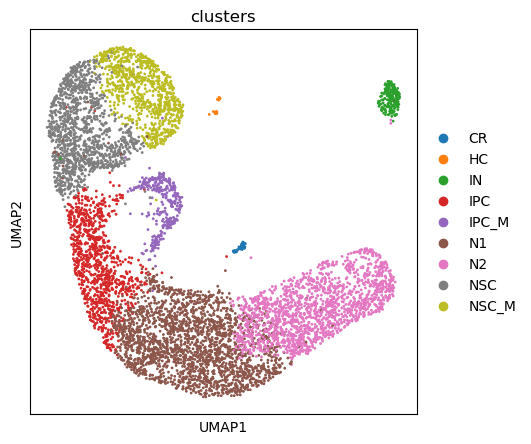

In [108]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='clusters')

#ATAC
# sc.pl.umap(atac, color='celltype')

In [109]:
rna

AnnData object with n_obs × n_vars = 7469 × 2000
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'varian

In [110]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([ 43.,  50.,  35.,  39.,  50.,  48.,  49.,  58.,  46.,  46.,  51.,
         46.,  63.,  52.,  46.,  51.,  49.,  50.,  49.,  64.,  54.,  59.,
         54.,  54.,  58.,  42.,  56.,  46.,  60.,  49.,  38.,  47.,  92.,
         95., 211.]),
 array([0.00060249, 0.01487099, 0.02913949, 0.04340799, 0.05767649,
        0.07194499, 0.08621349, 0.10048199, 0.11475049, 0.12901899,
        0.14328749, 0.15755599, 0.17182449, 0.18609299, 0.20036149,
        0.21462999, 0.22889849, 0.243167  , 0.2574355 , 0.271704  ,
        0.2859725 , 0.300241  , 0.3145095 , 0.328778  , 0.3430465 ,
        0.357315  , 0.3715835 , 0.385852  , 0.4001205 , 0.414389  ,
        0.4286575 , 0.442926  , 0.4571945 , 0.471463  , 0.4857315 ,
        0.5       ]),
 <BarContainer object of 35 artists>)

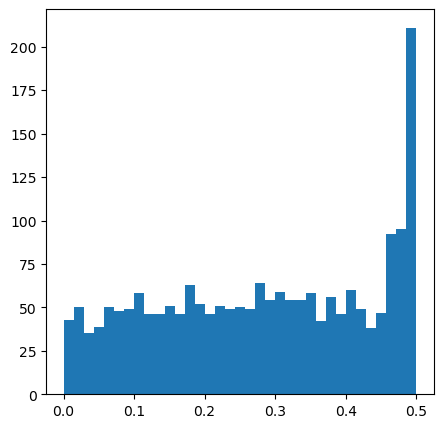

In [111]:
acc = (rna.X != 0).sum(axis=0) / rna.shape[0]
acc_score = abs(.5 - acc)
rna.var['acc_score'] = acc_score.A.T
rna.var['acc_score_rank'] = rna.var['acc_score'].rank(ascending=False)
plt.hist(rna.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [112]:
n_sample_cells = 250
n_sample_peaks = 500

In [113]:
n_cell_types = len(set(rna.obs['clusters']))

In [114]:
n_cell_types

9

In [115]:
rna.shape

(7469, 2000)

In [116]:
rna.obs['clusters'].value_counts()

clusters
N1       2192
N2       1614
NSC      1233
IPC       979
NSC_M     853
IPC_M     337
IN        198
CR         43
HC         20
Name: count, dtype: int64

In [119]:
rna.shape

(7469, 2000)

In [131]:
 # int(n_sample_cells * 1.5)
n_select = 35
# n_select =  int(n_sample_cells / n_cell_types) # bug if > 20
obs_sample = rna.obs.groupby('clusters').sample(n_select, random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(rna.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample),rna.var_names.isin(var_sample)].copy()
ad.shape

(276, 500)

In [132]:
ad.obs['clusters'].value_counts()

clusters
N2       35
N1       35
NSC      35
IPC      34
IPC_M    33
NSC_M    33
IN       32
CR       24
HC       15
Name: count, dtype: int64

In [133]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [134]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(276, 276)

In [135]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

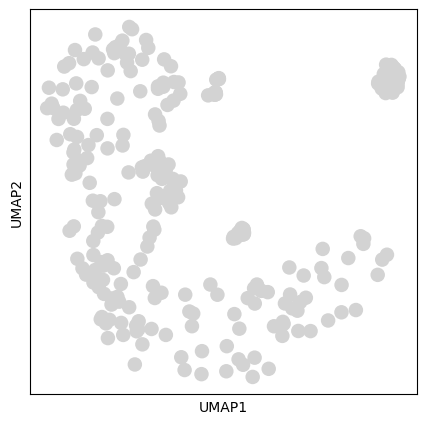

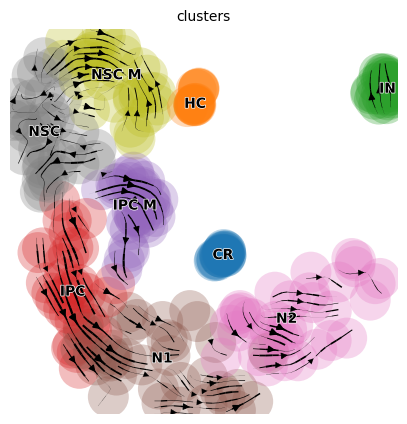

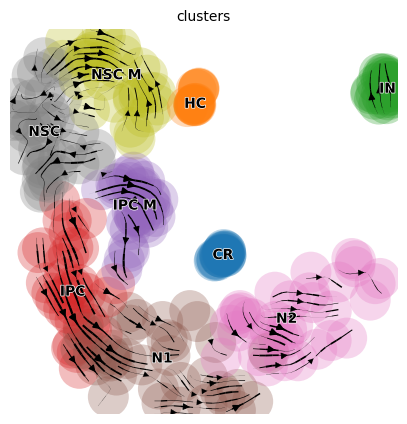

In [136]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [137]:
# ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
# ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
# ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

# print('features by chromosome')
# extend = 50
# ad.var['chr'].value_counts()

In [138]:
# ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
# ad.var['summit.start'] = ad.var['summit'] - extend
# ad.var['summit.end'] = ad.var['summit'] + extend
# ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['chr'] = 'chr' + ad.var['Chromosome'].astype(str)
ad.var['summit.start'] = ad.var['tss_start'].astype(str)
ad.var['summit.end'] = ad.var['tss_end'].astype(str)
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [139]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.local/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpg9k04_1c
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.local/bin/bedtools', 'getfasta', '-fi', '../../../annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpg9k04_1c', '-fo', '/tmp/tmpa106oa_6']
/home/ilibarra/.local/bin/bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpg9k04_1c -fo /tmp/tmpa106oa_6


500

In [140]:
!head  /tmp/tmpluxqk68o

head: cannot open '/tmp/tmpluxqk68o' for reading: No such file or directory


In [141]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [142]:
counts.shape

(500, 276)

In [143]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [144]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [145]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(500, 277)

In [146]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(500, 277)

In [147]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [148]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [149]:
# next_data.index

In [150]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [151]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [152]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(497, 276)

In [153]:
ad.shape, df.shape

((276, 500), (497, 276))

In [154]:
ad = ad[:,~zero_counts].copy()


In [155]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(137172, 3)
276
batch
184    497
185    497
186    497
187    497
188    497
      ... 
3      497
4      497
5      497
6      497
7      497
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
AGCCATGTGATCCTCTCTTGGGACCTTCATTCTGCACTGATCATCTGGCATCCCTGTAAGTGGGTACCAGCATTCATGCATCAACACAGGAGGTTAGACTGATAGGGAAAAAATCTGCACCAGCCTTTTACATACAGTAGGTGTGTTTCTCTTCTAGCTGCTCGGGTCTCACTGGCAATCTGTAGAAAGAGCTGTGTTAG,1.0,2.497785,0
GAGGCGCGGTTGGAAGTCGTTACTTTGAGGGGGGGCAGTCACCGGGCGATCCACCTTAGTCGAAGCTCAGAAGGGAACGGCTCAGGGACCAGGGTGGGCTACTTTTTTTATTTTCCGGGGCTTTTGATTTTTCTTGTCTTTTGCTTCGGGCCGATTGTCGCTCACAAAAAAAGAAAAAAAACAAAAAAACAAAAACCTGA,1.0,0.482273,0
GGCAGCGGTTCCTCAAGGCGGCGGGCGCCGGCGTCTTCAGAGCGCCATGCGAGCCGCGGAGCGAGTGTGGCATCTCTACCAGGCGGGGTACCAGCCTCTATGCCAGGCCATATGGGCTTGGCACGTCACGGGCAGCAGCTATCACATGAGAGACGGTGATTGGCATGCGTCTGCATTGGGGGAGAGCCGGCTCCCCCGGG,1.0,1.973737,0
GTTTTTTTTTTTTTTTTTTTTTTTTAATCAGTTCACTCAGAGTGCAAGAAGGGTCTCTGATGTGGCAGGGAGCTGGGTACCTGGGACCTCAGATGGCTCCGGGTGAGCAAGGCTCGAGAGCCTTTTTCTAGTGCAGGTTTGGGGGAGGAGGAGGAGGGAAGGGCGTTGGGGGGGATGGGGAAGCACATAGAAATGAGTTT,1.0,2.683385,0
CTGTAACTGAAGCTTAGCGAACACCCCCAACCTCCTATGATTAATTACATGCTTTTTTTTCTTCAATTCACAGCCTGCATTAACAGCTAGAAAGGTTTCGTTTATAACGCACAGGAAATTGCAGGGTAGGAAAAAAAAGATTGCACAGGCAAGCTCAGAATGCTCTAATGAGCAATGTGCTAGCCCTTTCTCTTAGAAAA,1.0,1.883696,0


### Simple motif enrichment

In [156]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [157]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [158]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [159]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [160]:
reduced_groups = pwms

In [161]:
df

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,275
seq,,,,,,,,,,,,,,,,,,,,,
AGCCATGTGATCCTCTCTTGGGACCTTCATTCTGCACTGATCATCTGGCATCCCTGTAAGTGGGTACCAGCATTCATGCATCAACACAGGAGGTTAGACTGATAGGGAAAAAATCTGCACCAGCCTTTTACATACAGTAGGTGTGTTTCTCTTCTAGCTGCTCGGGTCTCACTGGCAATCTGTAGAAAGAGCTGTGTTAG,2.497785,0.437498,1.093735,2.990722,0.000000,1.064260,0.788949,3.169403,0.434187,2.342377,...,0.000000,0.000000,0.00000,2.92992,3.264245,2.206896,0.756481,2.429829,2.934479,2.930838
GAGGCGCGGTTGGAAGTCGTTACTTTGAGGGGGGGCAGTCACCGGGCGATCCACCTTAGTCGAAGCTCAGAAGGGAACGGCTCAGGGACCAGGGTGGGCTACTTTTTTTATTTTCCGGGGCTTTTGATTTTTCTTGTCTTTTGCTTCGGGCCGATTGTCGCTCACAAAAAAAGAAAAAAAACAAAAAAACAAAAACCTGA,0.482273,2.795276,2.295996,0.620089,0.810206,0.667495,0.000000,0.904434,0.434187,0.000000,...,3.314856,0.000000,0.00000,0.00000,0.000000,0.000000,0.756481,0.000000,0.661377,0.960511
GGCAGCGGTTCCTCAAGGCGGCGGGCGCCGGCGTCTTCAGAGCGCCATGCGAGCCGCGGAGCGAGTGTGGCATCTCTACCAGGCGGGGTACCAGCCTCTATGCCAGGCCATATGGGCTTGGCACGTCACGGGCAGCAGCTATCACATGAGAGACGGTGATTGGCATGCGTCTGCATTGGGGGAGAGCCGGCTCCCCCGGG,1.973737,0.437498,1.093735,2.567047,0.485007,1.901523,0.788949,2.885423,0.000000,1.510110,...,0.000000,0.950548,0.00000,0.00000,2.333953,2.487267,1.182196,1.585934,2.647905,2.632194
GTTTTTTTTTTTTTTTTTTTTTTTTAATCAGTTCACTCAGAGTGCAAGAAGGGTCTCTGATGTGGCAGGGAGCTGGGTACCTGGGACCTCAGATGGCTCCGGGTGAGCAAGGCTCGAGAGCCTTTTTCTAGTGCAGGTTTGGGGGAGGAGGAGGAGGGAAGGGCGTTGGGGGGGATGGGGAAGCACATAGAAATGAGTTT,2.683385,2.386823,1.093735,3.073537,0.485007,2.517065,1.224412,0.551161,0.967411,2.790224,...,2.797147,0.000000,0.00000,2.92992,0.000000,2.206896,1.182196,3.016479,0.000000,2.840849
CTGTAACTGAAGCTTAGCGAACACCCCCAACCTCCTATGATTAATTACATGCTTTTTTTTCTTCAATTCACAGCCTGCATTAACAGCTAGAAAGGTTTCGTTTATAACGCACAGGAAATTGCAGGGTAGGAAAAAAAAGATTGCACAGGCAAGCTCAGAATGCTCTAATGAGCAATGTGCTAGCCCTTTCTCTTAGAAAA,1.883696,0.437498,1.785660,2.498827,0.000000,0.667495,3.354277,2.284747,0.000000,2.342377,...,0.000000,2.353541,2.54587,1.86473,2.333953,2.356876,0.756481,2.308798,2.339359,1.764575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTGGTCCTAATCTCTTAAAGGAAGGGAGTTGGGCATGAACCAGTGATGCAGCTGGCAAGCATTGTTCCCCTTGGTTTCTGCTGTGTTTCCTTGGTCACGAATTCCTTGATCTGAGGTAACAATACTACACAGAATCTCAAGTAGCCCAGCCTTCAGGTTCCTGCCCTGACTTCTCTCAGTGATGGATTGTGACATGGAA,0.000000,0.000000,0.000000,0.000000,1.055203,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GGCGCTGTGGACGCCTCCAGGAGCAGCCATCCCTGGTAACTGATGACGTAGCTAAGCTCAGCCTCTTGATTGGACCAGGGAATCCGCACTCCTTCAGTTAGGGGGATTCTAACAAGCCCGAAGGAAAGAGAAGGTTAGTCATGGTGTAGTCCTGCCACAGGCGGCGTGTCCAGCTCACTCCCCGCCCCCGTACAGTCCCT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GGAGATCTGCCAGGATCCCTGAGCTCCACCTCCATCTGCCCGGTAGGTCAGCTGGGTTTGGCCTGGATCCAGAAAGCAGGCGACACACTTCCCCGATTCGTAGTTGGACCGGGGCACCGTAGCCAGGGTCCCACACTCTTCGGCGGGCTGCATGGACTGAGCCAATTCGGTGTGGAAGATCTCCTGGCTGTGGCGGTGTG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [162]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [163]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [164]:
len(pwms)

286

In [165]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [166]:
rna_sample.shape, ad.shape

((276, 2000), (276, 497))

In [167]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [168]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(276, 276)
setting up log dynamic
no err


In [169]:
model.graph_module.conn_sparse.shape

torch.Size([276, 276])

setting up log dynamic
True
12
order None
0 out of 288...
break


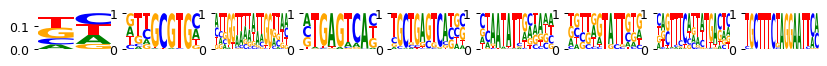

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


Current time: 2024-06-05 00:04:23.524102
	Loss: 280.772 , R2: 0.442
	Training time (model/function): (194.879s / 194.879s)
		per epoch (model/function): (21.653s/ 21.653s)
		per 1k samples: 43.568s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]


Current time: 2024-06-05 00:05:13.238406
	Loss: 260.572 , R2: 0.443
	Training time (model/function): (243.394s / 48.515s)
		per epoch (model/function): (12.810s/ 2.553s)
		per 1k samples: 5.138s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]


Current time: 2024-06-05 00:06:02.845967
	Loss: 242.688 , R2: 0.443
	Training time (model/function): (291.255s / 47.861s)
		per epoch (model/function): (15.329s/ 2.519s)
		per 1k samples: 5.068s
best loss 242.688
last five r2 values, by sequential filter optimization: ['0.443']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]


Current time: 2024-06-05 00:06:55.980587
	Loss: 233.617 , R2: 0.443
	Training time (model/function): (339.634s / 48.379s)
		per epoch (model/function): (17.875s/ 2.546s)
		per 1k samples: 5.123s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


Current time: 2024-06-05 00:07:31.238727
	Loss: 217.539 , R2: 0.443
	Training time (model/function): (373.795s / 34.161s)
		per epoch (model/function): (19.673s/ 1.798s)
		per 1k samples: 3.618s
best loss 217.539
last five r2 values, by sequential filter optimization: ['0.443', '0.443']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: Poi

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.32s/it]


Current time: 2024-06-05 00:08:21.593226
	Loss: 210.064 , R2: 0.443
	Training time (model/function): (420.250s / 46.455s)
		per epoch (model/function): (22.118s/ 2.445s)
		per 1k samples: 4.920s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


Current time: 2024-06-05 00:09:15.354689
	Loss: 196.319 , R2: 0.443
	Training time (model/function): (472.193s / 51.943s)
		per epoch (model/function): (24.852s/ 2.734s)
		per 1k samples: 5.501s
best loss 196.319
last five r2 values, by sequential filter optimization: ['0.443', '0.443', '0.443']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , crite

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


Current time: 2024-06-05 00:09:50.220396
	Loss: 191.488 , R2: 0.442
	Training time (model/function): (504.888s / 32.695s)
		per epoch (model/function): (26.573s/ 1.721s)
		per 1k samples: 3.462s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.86s/it]


Current time: 2024-06-05 00:13:12.640140
	Loss: 180.385 , R2: 0.442
	Training time (model/function): (702.104s / 197.216s)
		per epoch (model/function): (36.953s/ 10.380s)
		per 1k samples: 20.885s
best loss 180.385
last five r2 values, by sequential filter optimization: ['0.443', '0.443', '0.443', '0.442']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995970377135028, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 702.1040275096893s
Time per epoch (total): 0.122 s
True
12
order None
0 out of 288...
break


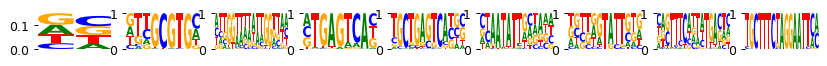

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.25s/it]


Current time: 2024-06-05 00:16:12.429030
	Loss: 270.169 , R2: 0.443
	Training time (model/function): (162.463s / 162.463s)
		per epoch (model/function): (18.051s/ 18.051s)
		per 1k samples: 36.321s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:00<00:00, 30.03s/it]


Current time: 2024-06-05 00:26:19.302544
	Loss: 258.947 , R2: 0.445
	Training time (model/function): (763.061s / 600.597s)
		per epoch (model/function): (40.161s/ 31.610s)
		per 1k samples: 63.602s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:28<00:00, 16.41s/it]


Current time: 2024-06-05 00:32:24.242862
	Loss: 242.645 , R2: 0.444
	Training time (model/function): (1091.297s / 328.236s)
		per epoch (model/function): (57.437s/ 17.276s)
		per 1k samples: 34.760s
best loss 242.645
last five r2 values, by sequential filter optimization: ['0.444']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonL

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.88s/it]


Current time: 2024-06-05 00:34:56.923871
	Loss: 233.612 , R2: 0.445
	Training time (model/function): (1228.930s / 137.633s)
		per epoch (model/function): (64.681s/ 7.244s)
		per 1k samples: 14.575s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:24<00:00, 16.21s/it]


Current time: 2024-06-05 00:40:22.565648
	Loss: 217.537 , R2: 0.445
	Training time (model/function): (1553.049s / 324.119s)
		per epoch (model/function): (81.739s/ 17.059s)
		per 1k samples: 34.324s
best loss 217.537
last five r2 values, by sequential filter optimization: ['0.444', '0.445']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:00<00:00, 15.03s/it]


Current time: 2024-06-05 00:45:35.510670
	Loss: 210.058 , R2: 0.446
	Training time (model/function): (1853.654s / 300.605s)
		per epoch (model/function): (97.561s/ 15.821s)
		per 1k samples: 31.834s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:56<00:00, 17.81s/it]


Current time: 2024-06-05 00:51:36.485555
	Loss: 196.317 , R2: 0.446
	Training time (model/function): (2209.793s / 356.139s)
		per epoch (model/function): (116.305s/ 18.744s)
		per 1k samples: 37.715s
best loss 196.317
last five r2 values, by sequential filter optimization: ['0.444', '0.445', '0.446']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  6.00s/it]


Current time: 2024-06-05 00:53:53.686171
	Loss: 191.481 , R2: 0.446
	Training time (model/function): (2329.705s / 119.913s)
		per epoch (model/function): (122.616s/ 6.311s)
		per 1k samples: 12.699s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.29s/it]


Current time: 2024-06-05 00:56:01.379643
	Loss: 180.382 , R2: 0.446
	Training time (model/function): (2455.439s / 125.734s)
		per epoch (model/function): (129.234s/ 6.618s)
		per 1k samples: 13.315s
best loss 180.382
last five r2 values, by sequential filter optimization: ['0.444', '0.445', '0.446', '0.446']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9997437251180776, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 2455.439304113388s
Time per epoch (total): 0.427 s


In [170]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 10
n_epochs_kernel = 20
log_each=75
n_unfreeze_kernels=70

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [171]:
lib_sizes = train.dataset.rounds.sum(axis=0).flatten()

In [172]:
model.device

device(type='cuda', index=0)

In [173]:
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

noack_2022_use_logdynamic_0.pth
noack_2022_use_logdynamic_1.pth


In [174]:
ad.shape

(276, 497)

In [175]:
ad.write('noack_2022_sample_train.h5ad')

In [176]:
import pickle
pickle.dump(train, open('train_dataloader.pkl', 'wb'))